# Understand activation functions

Idea is develop an intuition of the purpose of activation function and how it transforms the input data.

A feature map from a fully-connected layer can be written as :
$$
\mathbf{f}(\mathbf{x}) = \text{activation}(\mathbf{b} + \langle \mathbf{W}, \mathbf{x} \rangle )
$$

Non-linearity of the feature map depends on the choice of activation. We consider ReLU (Rectified Linear Unit) and `tanh` activation.


In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from keras import backend as K

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


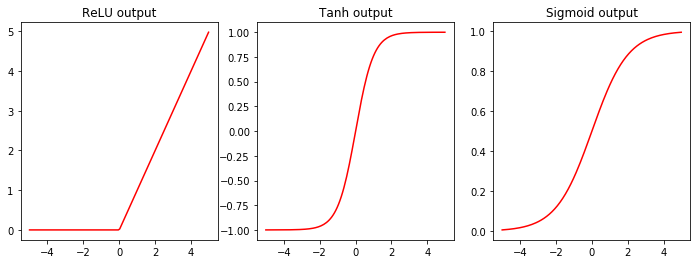

In [3]:
x = np.arange(-5.0, 5.0, 0.075)
X = K.variable(x)

plt.figure(figsize=(12,4))
plt.subplot(131)
y = K.relu(X).eval()
plt.plot(x, y, '-r')
plt.title("ReLU output")
plt.subplot(132)
y = K.tanh(X).eval()
plt.plot(x, y, '-r')
plt.title("Tanh output")
plt.subplot(133)
y = K.sigmoid(X).eval()
plt.plot(x, y, '-r')
plt.title("Sigmoid output")

## Examples

### 1. Feature map computation without learning

Let's define a simple network with 1 fully-connected layer with ReLU activation and N output. 
We initialize also the weights $\mathbf{W}$ to one, bias $\mathbf{b}$ to zero and analyse the output feature map. 
From the definition of the feature map, it is simple to calculate the output analytically:
$$
f_j(\mathbf{x}) = \text{relu}( \sum_{i} x_i ),\text{ for any j}
$$


In [4]:
from keras.layers import Input, Dense
from keras.models import Model

In [5]:
n_dim = 10
x_in = Input((n_dim,))
x_out = Dense(5, init='one', activation='relu')(x_in)
model = Model(input=x_in, output=x_out)
model.summary()

print "Weights W : "
print model.get_layer(index=1).W.eval()

print "Bias b : "
print model.get_layer(index=1).b.eval()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 5)             55          input_1[0][0]                    
Total params: 55
Trainable params: 55
Non-trainable params: 0
____________________________________________________________________________________________________
Weights W : 
CudaNdarray([[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]])
Bias b : 
CudaNdarray([ 0.  0.  0.  0.  0.])


Let's define input data as a batch of 

In [6]:
x = np.array([    
    [-2]*10,
    [-1]*10,
    [0]*10,
    [1]*10,
    [2]*10,
    np.arange(-0.5, 1.5, 0.2)
])
y = model.predict(x)

In [7]:
print "Feature map output"
print y

Feature map output
[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [ 10.          10.          10.          10.          10.        ]
 [ 20.          20.          20.          20.          20.        ]
 [  3.99999976   3.99999976   3.99999976   3.99999976   3.99999976]]


Thus, we observe the result as it is computed analytically above.


### 2. Learn and predict a quadratic function 

Now let's consider another example, we try to learn weights to predict a quadratic function result:
$$f_{\text{true}}(\mathbf{x}) =  \|x\|^2$$

Feature map obtained from a single fully-connected layer is 
$$
f_{\text{pred}}(\mathbf{x}) = b + \langle \mathbf{W}, \mathbf{x} \rangle
$$

There is no activation on the layer because we perform a value prediction (regression). With a single layer it seems there is no way to learn correctly such function.

In [8]:
n_samples = 500
X = 2.0 * np.random.rand(n_samples, 2) - 1.0
Y = X[:,0]**2 + X[:,1]**2

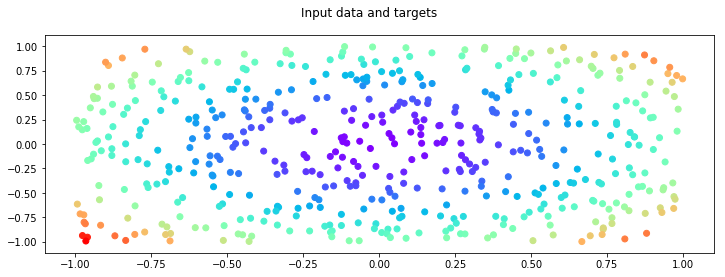

In [9]:
args = Y.argsort()
y_min = Y.min()
y_max = Y.max()
plt_cmap = plt.cm.get_cmap('rainbow')
colors = [plt_cmap((y - y_min)*1.0/(y_max - y_min)) for y in Y[args]]

plt.figure(figsize=(12,4))
plt.suptitle("Input data and targets")
_ = plt.scatter(X[args,0], X[args,1], color=colors, cmap='rainbox')

In [10]:
n_dim = 2
x_in = Input((n_dim,))
x_out = Dense(1)(x_in)
model = Model(input=x_in, output=x_out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             3           input_2[0][0]                    
Total params: 3
Trainable params: 3
Non-trainable params: 0
____________________________________________________________________________________________________


In [11]:
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])

In [12]:
history = model.fit(X, Y, validation_split=0.3, batch_size=64, nb_epoch=1000, shuffle=True, verbose=0)

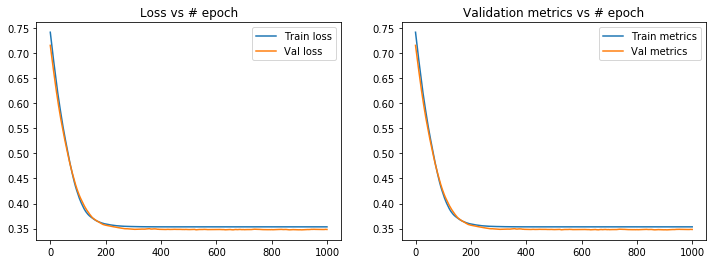

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(122)
plt.plot(history.history['mean_absolute_error'], label='Train metrics')
plt.plot(history.history['val_mean_absolute_error'], label='Val metrics')
plt.title("Validation metrics vs # epoch")
plt.legend()

In [14]:
X_test = np.random.rand(100, 2)
Y_test = np.hypot(X_test[:,0], X_test[:,1])

In [15]:
Y_pred = model.predict(X_test)

In [16]:
args = Y_test.argsort()
y_true = Y_test[args]
y_pred = Y_pred.ravel()[args]

In [17]:
from sklearn.metrics import mean_absolute_error

In [18]:
mean_absolute_error(y_true, y_pred)

0.24582809985451831

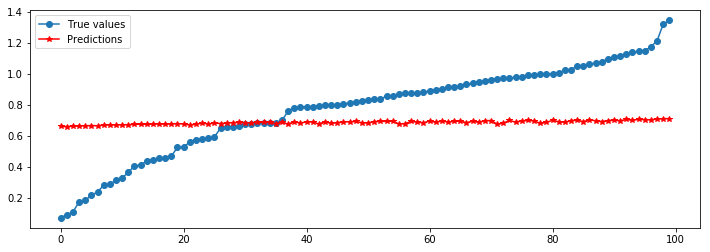

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, 'o-', label="True values")
plt.plot(y_pred, '*-r', label="Predictions")
_ = plt.legend()

Checkout the model on a single input value

In [20]:
x = np.array([-1.0, 1.0])
y = model.predict(x[None, :])
print y, x[0]**2 + x[1]**2

[[ 0.63745141]] 2.0


Let's look inside the network to see what happens and how it can predict the square function.

The weights are:

In [21]:
w = np.array(model.get_layer(index=1).W.eval())
b = np.array(model.get_layer(index=1).b.eval())
print "Weights W: "
print w, w.shape
print "Bias b: "
print b, b.shape

Weights W: 
[[ 0.03886858]
 [ 0.01772568]] (2L, 1L)
Bias b: 
[ 0.65859431] (1L,)


We can compute the prediction manually

In [22]:
x = np.array([-1.0, 1.0])

def _relu(x):
    y = x.copy()
    y[y<0] = 0
    return y

print _relu(np.dot(x, w) + b)

[ 0.63745141]


#### Let's try a deeper networks: 

a) `input -> [Dense: 50] -> [Dense: 1] -> output`. Feature map obtained from these fully-connected layers is 
$$
f_{\text{pred}}(\mathbf{x}) = b_2 + \langle \mathbf{W}_2, \text{activation}(\mathbf{b}_1 + \langle \mathbf{W}_1, \mathbf{x} \rangle ) \rangle 
$$

Let's compare ReLU with another one, e.g `tanh`.

In [23]:
n_dim = 2
x_in = Input((n_dim,))

x = Dense(50, activation='relu')(x_in)
x_out = Dense(1, name='output_1')(x)

x = Dense(50, activation='tanh')(x_in)
x_out2 = Dense(1, name='output_2')(x)

model = Model(input=x_in, output=[x_out, x_out2])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 50)            150         input_3[0][0]                    
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 50)            150         input_3[0][0]                    
____________________________________________________________________________________________________
output_1 (Dense)                 (None, 1)             51          dense_3[0][0]                    
___________________________________________________________________________________________

In [24]:
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])

In [25]:
history = model.fit(X, [Y, Y], validation_split=0.3, batch_size=64, nb_epoch=1000, shuffle=True, verbose=0)

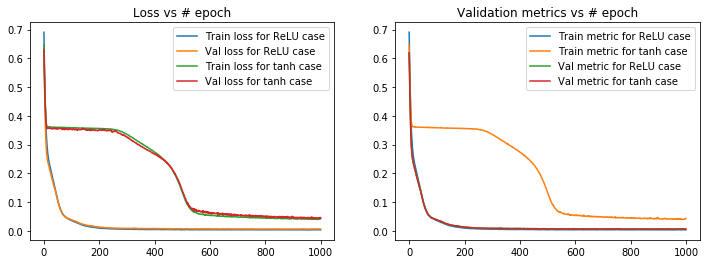

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['output_1_loss'], label='Train loss for ReLU case')
plt.plot(history.history['val_output_1_loss'], label='Val loss for ReLU case')
plt.plot(history.history['output_2_loss'], label='Train loss for tanh case')
plt.plot(history.history['val_output_2_loss'], label='Val loss for tanh case')
plt.title("Loss vs # epoch")

plt.legend()
plt.subplot(122)
plt.plot(history.history['output_1_mean_absolute_error'], label='Train metric for ReLU case')
plt.plot(history.history['output_2_mean_absolute_error'], label='Train metric for tanh case')
plt.plot(history.history['val_output_1_mean_absolute_error'], label='Val metric for ReLU case ')
plt.plot(history.history['val_output_1_mean_absolute_error'], label='Val metric for tanh case')
plt.title("Validation metrics vs # epoch")
plt.legend()


In [27]:
X_test = np.random.rand(100, 2)
Y_test = np.hypot(X_test[:,0], X_test[:,1])

In [28]:
Y_pred_1, Y_pred_2 = model.predict(X_test)

In [29]:
args = Y_test.argsort()
y_true = Y_test[args]
y_pred_1 = Y_pred_1.ravel()[args]
y_pred_2 = Y_pred_2.ravel()[args]

In [30]:
from sklearn.metrics import mean_absolute_error

In [31]:
mean_absolute_error(y_true, y_pred_1), mean_absolute_error(y_true, y_pred_2)

(0.16291937922831273, 0.12368422987991773)

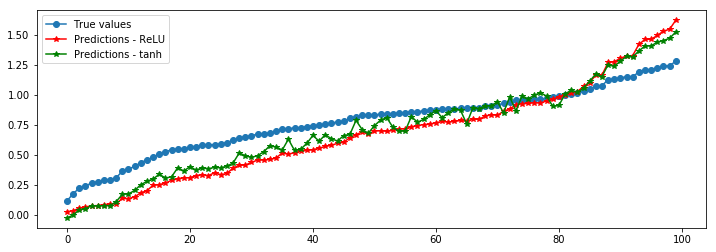

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, 'o-', label="True values")
plt.plot(y_pred_1, '*-r', label="Predictions - ReLU")
plt.plot(y_pred_2, '*-g', label="Predictions - tanh")
_ = plt.legend()

Checkout the model on a single input value

In [33]:
x = np.array([-1.0, 0.55])
y_1, y_2 = model.predict(x[None, :])
print y_1, y_2, x[0]**2 + x[1]**2

[[ 1.29011989]] [[ 1.21546972]] 1.3025


Let's look inside the network to see what happens and how it can predict the square function.

The weights are:

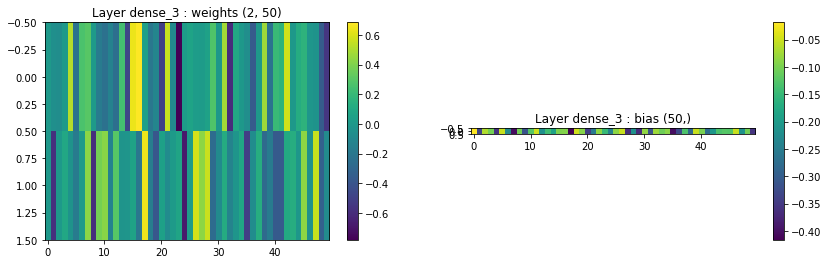

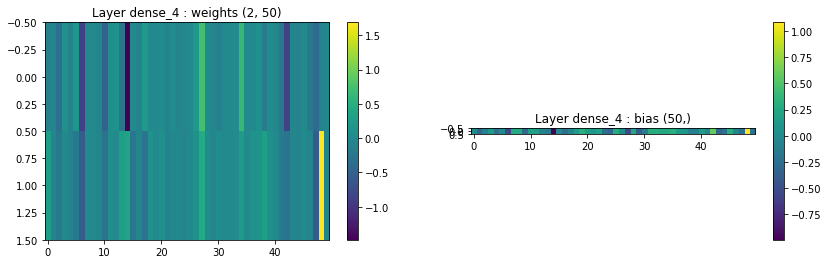

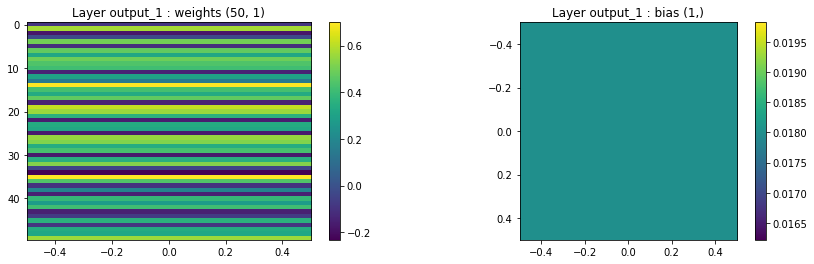

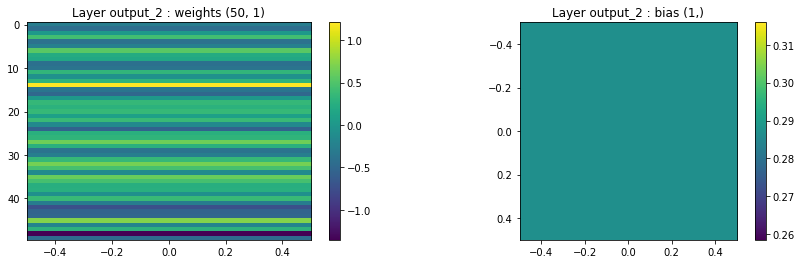

In [34]:
layers = list(model.layers)
layers.remove(model.input_layers[0])
for layer in layers:
    weights = layer.W.eval()
    b = layer.b.eval()
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title("Layer {} : weights {}".format(layer.name, weights.shape))
    plt.imshow(weights, interpolation='none', aspect='auto')    
    plt.colorbar()
    plt.subplot(122)
    plt.title("Layer {} : bias {}".format(layer.name, b.shape))    
    b = np.expand_dims(b, axis=0)    
    plt.imshow(b, interpolation='none')    
    plt.colorbar()
    

Display the transformation on a data by each layer

In [35]:
def get_layer_output_func(layer_name, model):
    inputs = [K.learning_phase()] + model.inputs
    output_layer = model.get_layer(name=layer_name)
    outputs = output_layer.output
    return K.function(inputs, [outputs])
    
    
def compute_layer_output(input_data, layer_output_f):
    return layer_output_f([0] + [input_data])


def compute_layer_outputs(input_data, model, layer_output_f_dict={}, layer_names=None):
    """
    Method to compute (all or only those specified by `layer_names`) layer outputs on `input_data` for a given `model`
    :return: tuple of pairs: [("layer_name_1", ndarray), ...]
    """
    if layer_names is None:
        inputs_outputs = model.input_layers
        inputs_outputs.extend(model.output_layers)
        layer_names = [layer.name for layer in model.layers if layer not in inputs_outputs]        
    else:
        all_layer_names = [layer.name for layer in model.layers]
        assert set(layer_names) & set(all_layer_names) == set(layer_names), \
            "Items {} of layer_names are not in model".format(set(layer_names) - set(layer_names))

    layer_outputs = []
    for layer_name in layer_names:
        print("-- %s" % layer_name)
        if layer_name not in layer_output_f_dict:
            layer_output_f_dict[layer_name] = get_layer_output_func(layer_name, model)
        layer_outputs.append((layer_name, compute_layer_output(input_data, layer_output_f_dict[layer_name])))
    return layer_outputs

In [36]:
x = np.array([
    [0.0, 0.0],
    [0.5, 0.0],
    [-0.5, 0.0],
    [0.5, 1.5],
    [0.5, -1.5],
    [-0.5, -1.5],
    [-0.5, 1.5],
])

# Targets should be 
print "True values : "
print x[:, 0]**2 + x[:, 1]**2

layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(x[5:6,:], model, layer_output_f_dict)

for layer_name, layer_output in layer_outputs:
    print "\n", layer_name
    print layer_output[0], layer_output[0].shape

print "\n Predictions :"
y_1, y_2 = model.predict(x)
print y_1
print y_2

True values : 
[ 0.    0.25  0.25  2.5   2.5   2.5   2.5 ]
-- dense_3
-- dense_4

dense_3
[[ 0.          0.55758667  0.          0.          0.          0.31662434
   0.          0.          0.76049346  0.          0.          0.21109578
   0.          0.          0.07474752  0.          0.          0.
   0.28680545  0.53679371  0.          0.          0.          0.13108973
   0.76332164  0.          0.          0.          0.          0.
   0.03634246  0.          0.40852499  0.          0.          0.39292833
   0.          0.          0.          0.31481388  0.34183541  0.18561834
   0.          0.          0.          0.          0.01619186  0.
   0.5750618   0.02895999]] (1L, 50L)

dense_4
[[-0.37866983 -0.23680441  0.36406568  0.0648357  -0.10166162  0.21456157
   0.61727691  0.22654302  0.24411994 -0.22003481  0.67510521 -0.01550491
  -0.13808261 -0.45697954 -0.66846013  0.30199689 -0.16138023  0.2316229
  -0.040442    0.24593663 -0.02856651  0.2087232   0.18674485 -0.20105441


Let's compute the derivatives on $\mathbf{x}$ (Jacobian and Hessian matricies) of the output to observe a non-linearity of the output of the feature map. 
Implementation continues with `theano`


In [37]:
import theano
from theano import tensor as T

In [38]:
x_in = model.inputs[0]
feature_map_relu = T.flatten(model.outputs[0])
feature_map_tanh = T.flatten(model.outputs[1])
# print x_in.ndim, x_in.type(), feature_map_relu.ndim, feature_map_relu.type()

In [39]:
Jacobian_relu = T.jacobian(feature_map_relu, x_in)
jacobian_relu = theano.function([x_in], Jacobian_relu)

Jacobian_tanh = T.jacobian(feature_map_tanh, x_in)
jacobian_tanh = theano.function([x_in], Jacobian_tanh)

In [40]:
Jacobian_relu_flatten = T.flatten(Jacobian_relu)
Jacobian_tanh_flatten = T.flatten(Jacobian_tanh)

In [41]:
x_in_grid = np.mgrid[-10.0:10.0:30j,-10.0:10.0:30j].transpose([1,2,0])
x_in_grid = x_in_grid.reshape((np.prod(x_in_grid.shape[:2]), 2)).astype(np.float32)

In [42]:
uvs = np.array([jacobian_relu(x_in_grid[i:i+1,:])[0, 0] for i in range(x_in_grid.shape[0])])
uvs2 = np.array([jacobian_tanh(x_in_grid[i:i+1,:])[0, 0] for i in range(x_in_grid.shape[0])])

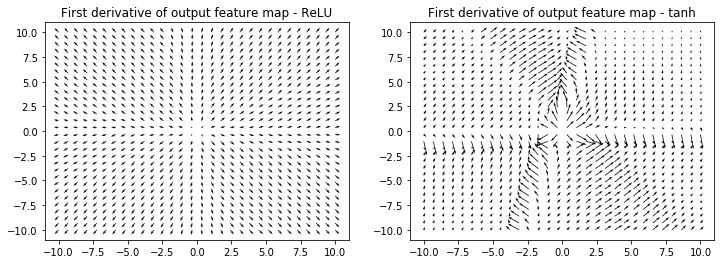

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("First derivative of output feature map - ReLU")
plt.quiver(x_in_grid[:,0], x_in_grid[:, 1], uvs[:,0], uvs[:,1])
plt.subplot(122)
plt.title("First derivative of output feature map - tanh")
plt.quiver(x_in_grid[:,0], x_in_grid[:, 1], uvs2[:,0], uvs2[:,1])

In [44]:
Hessian_relu, updates = theano.scan(lambda i, _y, _x: T.jacobian(_y[i], _x), sequences=T.arange(Jacobian_relu_flatten.shape[0]), non_sequences=[Jacobian_relu_flatten, x_in])
hessian_relu = theano.function([x_in], Hessian_relu, updates=updates)

Hessian_tanh, updates = theano.scan(lambda i, _y, _x: T.jacobian(_y[i], _x), sequences=T.arange(Jacobian_tanh_flatten.shape[0]), non_sequences=[Jacobian_tanh_flatten, x_in])
hessian_tanh = theano.function([x_in], Hessian_tanh, updates=updates)

In [45]:
hvalues_relu = np.array([hessian_relu(x_in_grid[i:i+1,:])[:, 0] for i in range(x_in_grid.shape[0])])
hvalues_tanh = np.array([hessian_tanh(x_in_grid[i:i+1,:])[:, 0] for i in range(x_in_grid.shape[0])])

In [46]:
print "Min/Max Hessian determinant (ReLU):", np.linalg.det(hvalues_relu).min(), np.linalg.det(hvalues_relu).max()
print "Min/Max Hessian determinant (tanh):", np.linalg.det(hvalues_tanh).min(), np.linalg.det(hvalues_tanh).max()

Min/Max Hessian determinant (ReLU): 0.0 0.0
Min/Max Hessian determinant (tanh): -6.23666 8.40322


b) `input -> [Dense: 100] -> [Dense: 100] -> [Dense: 1] -> output`. Feature map obtained from these fully-connected layers is 
$$
f_{\text{pred}}(\mathbf{x}) = b_3 + \langle \mathbf{W}_3, \text{relu}(\mathbf{b}_2 + \langle \mathbf{W}_2, \text{relu}(\mathbf{b}_1 + \langle \mathbf{W}_1, \mathbf{x} \rangle ) \rangle ) \rangle 
$$

However, as we saw in the previous example, second derivation of the feature map based on ReLU activation is zero. Thus, we will not, probably, obtain a good approximation of the target function.


In [47]:
n_dim = 2
x_in = Input((n_dim,))
x = Dense(100, activation='relu')(x_in)
x = Dense(100, activation='relu')(x)
x_out = Dense(1)(x)
model = Model(input=x_in, output=x_out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 100)           300         input_4[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 100)           10100       dense_5[0][0]                    
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 1)             101         dense_6[0][0]                    
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_____________________

In [48]:
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])

In [49]:
history = model.fit(X, Y, validation_split=0.3, batch_size=64, nb_epoch=1000, shuffle=True, verbose=0)

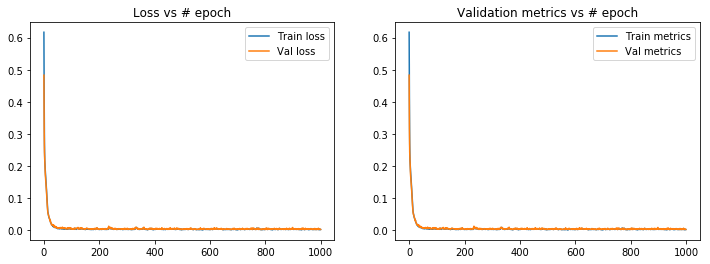

In [50]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(122)
plt.plot(history.history['mean_absolute_error'], label='Train metrics')
plt.plot(history.history['val_mean_absolute_error'], label='Val metrics')
plt.title("Validation metrics vs # epoch")
plt.legend()

In [51]:
X_test = np.random.rand(100, 2)
Y_test = np.hypot(X_test[:,0], X_test[:,1])

In [52]:
Y_pred = model.predict(X_test)

In [53]:
args = Y_test.argsort()
y_true = Y_test[args]
y_pred = Y_pred.ravel()[args]

In [54]:
from sklearn.metrics import mean_absolute_error

In [55]:
mean_absolute_error(y_true, y_pred)

0.16830754129379477

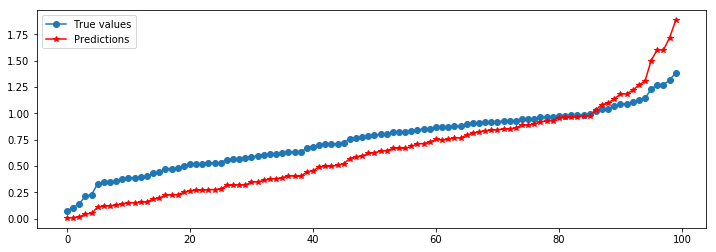

In [56]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, 'o-', label="True values")
plt.plot(y_pred, '*-r', label="Predictions")
_ = plt.legend()

c) `input -> [Dense: 100] -> [Dense: 100] -> [Dense: 1] -> output`. Feature map obtained from these fully-connected layers is 
$$
f_{\text{pred}}(\mathbf{x}) = b_3 + \langle \mathbf{W}_3, \text{tanh}(\mathbf{b}_2 + \langle \mathbf{W}_2, \text{tanh}(\mathbf{b}_1 + \langle \mathbf{W}_1, \mathbf{x} \rangle ) \rangle ) \rangle 
$$

In [57]:
n_dim = 2
x_in = Input((n_dim,))
x = Dense(100, activation='tanh')(x_in)
x = Dense(100, activation='tanh')(x)
x_out = Dense(1)(x)
model = Model(input=x_in, output=x_out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 100)           300         input_5[0][0]                    
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 100)           10100       dense_8[0][0]                    
____________________________________________________________________________________________________
dense_10 (Dense)                 (None, 1)             101         dense_9[0][0]                    
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_____________________

In [58]:
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])

In [59]:
history = model.fit(X, Y, validation_split=0.3, batch_size=64, nb_epoch=1000, shuffle=True, verbose=0)

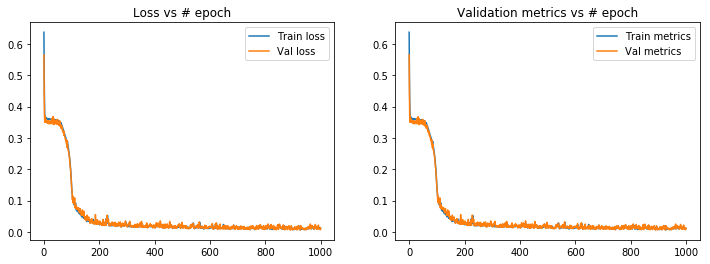

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(122)
plt.plot(history.history['mean_absolute_error'], label='Train metrics')
plt.plot(history.history['val_mean_absolute_error'], label='Val metrics')
plt.title("Validation metrics vs # epoch")
plt.legend()

In [61]:
X_test = np.random.rand(100, 2)
Y_test = np.hypot(X_test[:,0], X_test[:,1])

In [62]:
Y_pred = model.predict(X_test)

In [63]:
args = Y_test.argsort()
y_true = Y_test[args]
y_pred = Y_pred.ravel()[args]

In [64]:
from sklearn.metrics import mean_absolute_error

In [65]:
mean_absolute_error(y_true, y_pred)

0.14107992558846252

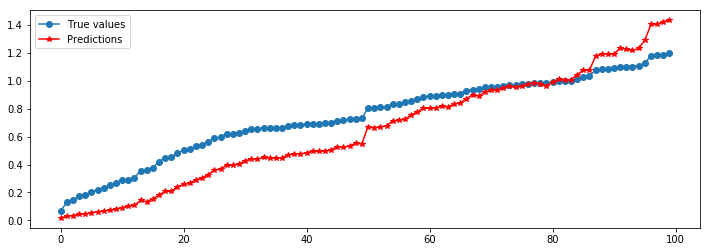

In [66]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, 'o-', label="True values")
plt.plot(y_pred, '*-r', label="Predictions")
_ = plt.legend()

Let's compute the derivatives on $\mathbf{x}$ (Jacobian and Hessian matricies) of the output to observe a non-linearity of the output of the feature map. 
Implementation continues with `theano`


In [67]:
import theano
from theano import tensor as T

In [68]:
x_in = model.inputs[0]
feature_map_tanh = T.flatten(model.outputs[0])

In [69]:
Jacobian_tanh = T.jacobian(feature_map_tanh, x_in)
jacobian_tanh = theano.function([x_in], Jacobian_tanh)

In [70]:
Jacobian_tanh_flatten = T.flatten(Jacobian_tanh)

In [71]:
x_in_grid = np.mgrid[-10.0:10.0:30j,-10.0:10.0:30j].transpose([1,2,0])
x_in_grid = x_in_grid.reshape((np.prod(x_in_grid.shape[:2]), 2)).astype(np.float32)

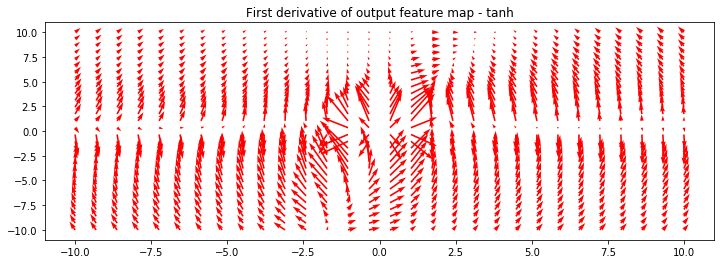

In [72]:
uvs = np.array([jacobian_tanh(x_in_grid[i:i+1,:])[0, 0] for i in range(x_in_grid.shape[0])])
plt.figure(figsize=(12, 4))
plt.title("First derivative of output feature map - tanh")
plt.quiver(x_in_grid[:,0], x_in_grid[:, 1], uvs[:,0], uvs[:,1], color='r')


In [73]:
Hessian_tanh, updates = theano.scan(lambda i, _y, _x: T.jacobian(_y[i], _x), sequences=T.arange(Jacobian_tanh_flatten.shape[0]), non_sequences=[Jacobian_tanh_flatten, x_in])
hessian_tanh = theano.function([x_in], Hessian_tanh, updates=updates)

In [74]:
hvalues_tanh = np.array([hessian_tanh(x_in_grid[i:i+1,:])[:, 0] for i in range(x_in_grid.shape[0])])

In [75]:
print "Min/Max Hessian determinant (tanh):", np.linalg.det(hvalues_tanh).min(), np.linalg.det(hvalues_tanh).max()

Min/Max Hessian determinant (tanh): -14.8655 16.0714


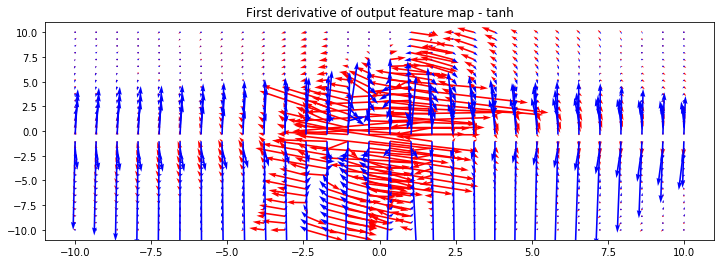

In [76]:
uvs = np.array([jacobian_tanh(x_in_grid[i:i+1,:])[0, 0] for i in range(x_in_grid.shape[0])])
plt.figure(figsize=(12, 4))
plt.title("First derivative of output feature map - tanh")
plt.quiver(x_in_grid[:,0], x_in_grid[:, 1], hvalues_tanh[:,0,0], hvalues_tanh[:,1,0], color='r')
plt.quiver(x_in_grid[:,0], x_in_grid[:, 1], hvalues_tanh[:,0,1], hvalues_tanh[:,1,1], color='b')


Checkout the model on a single input value

In [77]:
x = np.array([-1.0, 0.55])
y = model.predict(x[None, :])
print y, x[0]**2 + x[1]**2

[[ 1.28660953]] 1.3025


Let's look inside the network to see what happens and how it can predict the square function.

The weights are:

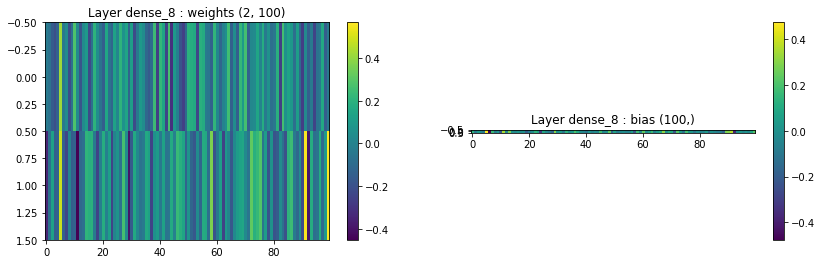

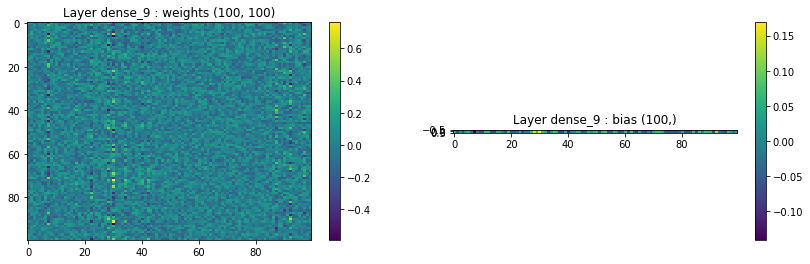

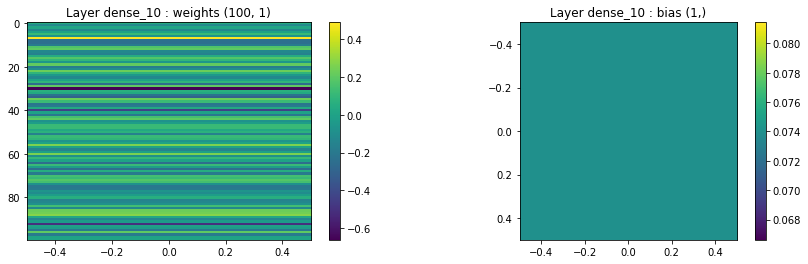

In [78]:
layers = list(model.layers)
layers.remove(model.input_layers[0])
for layer in layers:
    weights = layer.W.eval()
    b = layer.b.eval()
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title("Layer {} : weights {}".format(layer.name, weights.shape))
    plt.imshow(weights, interpolation='none', aspect='auto')    
    plt.colorbar()
    plt.subplot(122)
    plt.title("Layer {} : bias {}".format(layer.name, b.shape))    
    b = np.expand_dims(b, axis=0)    
    plt.imshow(b, interpolation='none')    
    plt.colorbar()
    

Display the transformation on a data by each layer

In [79]:
def get_layer_output_func(layer_name, model):
    inputs = [K.learning_phase()] + model.inputs
    output_layer = model.get_layer(name=layer_name)
    outputs = output_layer.output
    return K.function(inputs, [outputs])
    
    
def compute_layer_output(input_data, layer_output_f):
    return layer_output_f([0] + [input_data])


def compute_layer_outputs(input_data, model, layer_output_f_dict={}, layer_names=None):
    """
    Method to compute (all or only those specified by `layer_names`) layer outputs on `input_data` for a given `model`
    :return: tuple of pairs: [("layer_name_1", ndarray), ...]
    """
    if layer_names is None:
        inputs_outputs = model.input_layers
        inputs_outputs.extend(model.output_layers)
        layer_names = [layer.name for layer in model.layers if layer not in inputs_outputs]        
    else:
        all_layer_names = [layer.name for layer in model.layers]
        assert set(layer_names) & set(all_layer_names) == set(layer_names), \
            "Items {} of layer_names are not in model".format(set(layer_names) - set(layer_names))

    layer_outputs = []
    for layer_name in layer_names:
        print("-- %s" % layer_name)
        if layer_name not in layer_output_f_dict:
            layer_output_f_dict[layer_name] = get_layer_output_func(layer_name, model)
        layer_outputs.append((layer_name, compute_layer_output(input_data, layer_output_f_dict[layer_name])))
    return layer_outputs

In [80]:
x = np.array([
    [0.0, 0.0],
    [0.5, 0.0],
    [-0.5, 0.0],
    [0.5, 1.5],
    [0.5, -1.5],
    [-0.5, -1.5],
    [-0.5, 1.5],
])

# Targets should be 
print "True values : "
print x[:, 0]**2 + x[:, 1]**2

layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(x[5:6,:], model, layer_output_f_dict)

for layer_name, layer_output in layer_outputs:
    print "\n", layer_name
    print layer_output[0], layer_output[0].shape

print "\n Predictions :"
print model.predict(x)

True values : 
[ 0.    0.25  0.25  2.5   2.5   2.5   2.5 ]
-- dense_8
-- dense_9

dense_8
[[ 0.57611406  0.05354391 -0.07410872  0.29717812  0.17121777 -0.43201035
  -0.24885595  0.46598998  0.01995623  0.29105037 -0.14744306  0.76634681
   0.22942662  0.37446851 -0.34618488 -0.20565502 -0.22766767 -0.07401933
   0.33556879 -0.13009325 -0.26892588 -0.07104479 -0.01074385  0.46754593
  -0.37590122 -0.02454202 -0.0318246  -0.47491103 -0.28309366  0.74412942
   0.18387495 -0.09379552 -0.10467639  0.17847846  0.03032929 -0.14482237
   0.08960481  0.47723201 -0.21731442 -0.07430314 -0.15580925 -0.24998896
   0.15368809 -0.06529874 -0.14172773  0.13987397 -0.3554498  -0.18649739
   0.1583505   0.07036996 -0.13245673  0.00946067  0.13952024  0.04592766
   0.03002176 -0.376789   -0.16543749 -0.06413855 -0.29963192  0.16057281
   0.27350819 -0.13208008  0.42122528  0.01432245 -0.19635014  0.35887533
   0.03406731  0.21241827 -0.30678028 -0.15948838 -0.07936448 -0.06171557
  -0.26287487 -0.25114

## Appendix. Theano examples

### 1. Function derivations : jacobian and hessian

Let us consider a function $y(\mathbf{x}) = const + 1.2 \sum_i x_i + 3.4 \sum_{i \neq j} x_i x_j + 5.6 \sum_{i} x_i^2  $ where $x \in \mathbb{R}^2$. 
First derivatives of y over x are 
$$\frac{\partial y}{\partial x_i} = 1.2 + 11.2 x_{i} + 6.8 x_{\check{i}}$$
Hessian matrix is : 
$$\frac{\partial^2 y}{\partial x_i \partial x_j} = 11.2 \delta_{ij} +  6.8 \delta_{\check{i} j}$$

In [81]:
import theano
from theano import tensor as T

In [82]:
x = T.dvector('x')
y = 0.12 + 1.2 * T.sum(x, axis=0) + 3.4 * T.sum(x, axis=0) ** 2 + 2.2 * T.sum(x**2, axis=0)
print x.type(), x.ndim, y.type(), y.ndim

<TensorType(float64, vector)> 1 <TensorType(float64, scalar)> 0


In [83]:
jacobian = T.jacobian(y, x)
print jacobian.type(), jacobian.ndim

<TensorType(float64, vector)> 1


In [84]:
jacobian.eval({x: np.array([0.0, 0.0])}), jacobian.eval({x: np.array([1.0, 0.0])}), jacobian.eval({x: np.array([1.0, 1.0])})

(array([ 1.20000005,  1.20000005]),
 array([ 12.40000033,   8.00000024]),
 array([ 19.20000052,  19.20000052]))

In [85]:
hessian = T.hessian(y, x)
print hessian.type(), hessian.ndim

<TensorType(float64, matrix)> 2


In [86]:
hessian.eval({x: np.array([0.0, 0.0])})

array([[ 11.20000029,   6.80000019],
       [  6.80000019,  11.20000029]])

#### Same computations, but $x$ is now a matrix `(batch_size, 2)`

In [87]:
x = T.dmatrix('x')
y = 0.12 + 1.2 * T.sum(x, axis=1) + 3.4 * T.sum(x, axis=1) ** 2 + 2.2 * T.sum(x**2, axis=1)
print x.type(), x.ndim, y.type(), y.ndim

<TensorType(float64, matrix)> 2 <TensorType(float64, vector)> 1


In [88]:
jacobian = T.jacobian(y, x)
print jacobian.type(), jacobian.ndim

<TensorType(float64, 3D)> 3


In [89]:
jacobian.eval({x: np.array([[0.0, 0.0], ])}), jacobian.eval({x: np.array([[1.0, 0.0],])}), jacobian.eval({x: np.array([[1.0, 1.0], ])})

(array([[[ 1.20000005,  1.20000005]]]),
 array([[[ 12.40000033,   8.00000024]]]),
 array([[[ 19.20000052,  19.20000052]]]))

In [90]:
hessian, updates = theano.scan(lambda i, _y: T.jacobian(_y[i], x), sequences=T.arange(T.flatten(jacobian).shape[0]), non_sequences=[T.flatten(jacobian)])
print hessian.type(), hessian.ndim 

<TensorType(float64, 3D)> 3


In [91]:
hessian.eval({x: np.array([[0.0, 0.0], ])})

array([[[ 11.20000029,   6.80000019]],

       [[  6.80000019,  11.20000029]]])